In [2]:
import sys

sys.path.append("../sketchformer")
sys.path.append("../src")


In [3]:
from isketcher import InteractiveSketcher
import tensorflow as tf
import numpy as np
import pandas as pd


In [4]:
num_layers = 8
d_model = 64
dff = 128
num_heads = 4
dropout_rate = 0.1
target_object_num = 41


class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
    def __init__(self, d_model, warmup_steps=4000):
        super(CustomSchedule, self).__init__()

        self.d_model = d_model
        self.d_model = tf.cast(self.d_model, tf.float32)

        self.warmup_steps = warmup_steps

    def __call__(self, step):
        arg1 = tf.math.rsqrt(step)
        arg2 = step * (self.warmup_steps ** -1.5)

        return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)


learning_rate = CustomSchedule(d_model)
optimizer = tf.keras.optimizers.Adam(learning_rate, beta_1=0.9, beta_2=0.98,
                                     epsilon=1e-9)


In [5]:
# create model

interactive_sketcher = InteractiveSketcher(
    num_layers=num_layers, d_model=d_model, num_heads=num_heads, dff=dff,
    object_num=target_object_num, rate=dropout_rate)

# restore model
checkpoint_path = "./models/demo2"

ckpt = tf.train.Checkpoint(epoch=tf.Variable(1),
                           transformer=interactive_sketcher,
                           optimizer=optimizer)

ckpt_manager = tf.train.CheckpointManager(
    ckpt, checkpoint_path, max_to_keep=5)

if ckpt_manager.latest_checkpoint:
    ckpt.restore(ckpt_manager.latest_checkpoint)
    print('Latest checkpoint restored!!')


Latest checkpoint restored!!


In [6]:
dataset = np.load('../data/isketcher/dataset.npz')
x_test, y_test = dataset['x_test'], dataset['y_test']
print(x_test.shape)
print(y_test.shape)


(1113, 43, 132)
(1113, 43)


In [7]:
# class label
df = pd.read_csv('../outputs/sketchyscene_quickdraw.csv')
df = df.dropna(subset=['quickdraw_label'])
class_names = ['none']
for row in df.itertuples():
    class_names.append(row.quickdraw_label)
class_to_num = dict(zip(class_names, range(0, len(class_names))))

print(class_names)
print(len(class_names))
print(class_to_num)


['none', 'airplane', 'apple', 'hot air balloon', 'banana', 'basket', 'bee', 'bench', 'bicycle', 'bird', 'wine bottle', 'bucket', 'bus', 'butterfly', 'car', 'cat', 'chair', 'cloud', 'cow', 'cup', 'dog', 'duck', 'fence', 'flower', 'grapes', 'grass', 'horse', 'house', 'moon', 'mountain', 'face', 'pig', 'rabbit', 'sheep', 'star', 'streetlight', 'sun', 'table', 'tree', 'truck', 'umbrella']
41
{'none': 0, 'airplane': 1, 'apple': 2, 'hot air balloon': 3, 'banana': 4, 'basket': 5, 'bee': 6, 'bench': 7, 'bicycle': 8, 'bird': 9, 'wine bottle': 10, 'bucket': 11, 'bus': 12, 'butterfly': 13, 'car': 14, 'cat': 15, 'chair': 16, 'cloud': 17, 'cow': 18, 'cup': 19, 'dog': 20, 'duck': 21, 'fence': 22, 'flower': 23, 'grapes': 24, 'grass': 25, 'horse': 26, 'house': 27, 'moon': 28, 'mountain': 29, 'face': 30, 'pig': 31, 'rabbit': 32, 'sheep': 33, 'star': 34, 'streetlight': 35, 'sun': 36, 'table': 37, 'tree': 38, 'truck': 39, 'umbrella': 40}


In [8]:
# test

scene_index = 1
print(x_test[scene_index].shape)

print("----", 0, "-------")
print("real label: ", class_names[int(y_test[scene_index, 0])])
print("real position: ", x_test[scene_index, 0, -4:] * 750)

for i in range(1, len(x_test[scene_index])):

    c_out, p_out, _ = interactive_sketcher(
        x_test[scene_index, :i], training=False, look_ahead_mask=None)

    c_real_id = int(y_test[scene_index, i])
    if c_real_id == 0:
        break
    p_real = x_test[scene_index, i, -4:]

    c_pred = c_out[0, -1, :]  # 最後のスケッチを取得
    c_pred_id = tf.argmax(c_pred, axis=-1)
    p_pred = p_out[0, -1, :]  # 最後のスケッチを取得

    print("----", i, "-------")
    print("real label: ", class_names[c_real_id])
    print("pred label: ", class_names[c_pred_id])

    print("real position: ", p_real * 750)
    print("pred position: ", p_pred.numpy() * 750)


(43, 132)
---- 0 -------
real label:  sun
real position:  [250.      -20.      450.00003 180.     ]
---- 1 -------
real label:  cloud
pred label:  cloud
real position:  [320.  20. 590. 130.]
pred position:  [238.68571 153.40622 463.82788 322.16864]
---- 2 -------
real label:  tree
pred label:  cloud
real position:  [-130.   80.  270.  540.]
pred position:  [289.7195  263.48465 465.3022  434.48737]
---- 3 -------
real label:  chair
pred label:  tree
real position:  [140. 330. 380. 550.]
pred position:  [297.41376 304.80215 449.2894  458.17737]
---- 4 -------
real label:  chair
pred label:  grass
real position:  [100.00001 460.      439.99997 690.     ]
pred position:  [316.07516 432.8072  430.72562 547.9462 ]
---- 5 -------
real label:  table
pred label:  grass
real position:  [270. 380. 560. 590.]
pred position:  [320.40802 445.6164  424.60107 552.0774 ]
---- 6 -------
real label:  tree
pred label:  grass
real position:  [510.       40.      760.      450.00003]
pred position:  [313.13

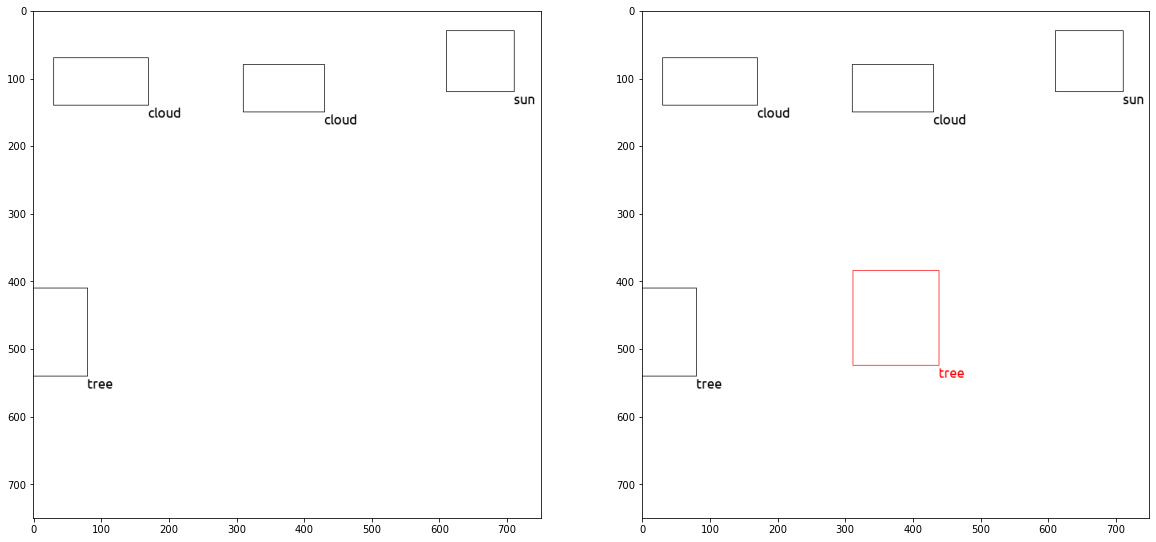

In [14]:
# draw canvas

from PIL import Image, ImageDraw, ImageFont
import matplotlib.pyplot as plt

canvas = Image.new('RGB', (750, 750), (255, 255, 255))

scene_index = 10
pred_index = 4

draw = ImageDraw.Draw(canvas)
r = 5
font = ImageFont.truetype("/usr/share/fonts/truetype/ubuntu/Ubuntu-R.ttf", size=20)

for i in range(pred_index):
    label = class_names[int(y_test[scene_index, i])]
    x0, y0, x1, y1 = x_test[scene_index, i, -4:] * 750
    draw.rectangle((x0, y0, x1, y1), outline=(0, 0, 0))
    draw.text((x1, y1), label, fill='black', font=font)

c_out, p_out, _ = interactive_sketcher(
    x_test[scene_index, :pred_index], training=False, look_ahead_mask=None)

c_pred = c_out[0, -1, :]  # 最後のスケッチを取得
c_pred_id = tf.argmax(c_pred, axis=-1)
x0, y0, x1, y1 = p_out[0, -1, :] * 750  # 最後のスケッチを取得

next_canvas = canvas.copy()
next_draw = ImageDraw.Draw(next_canvas)
next_draw.rectangle((x0, y0, x1, y1), outline=(255, 0, 0))
next_draw.text((x1, y1), class_names[c_pred_id], fill=(255, 0, 0), font=font)

# canvas.save(f'../outputs/canvas_{scene_index}_{pred_index}.png')
# next_canvas.save(f'../outputs/next_canvas_{scene_index}_{pred_index}.png')
plt.figure(figsize=(20, 20))
plt.subplot(121).imshow(canvas)
plt.subplot(122).imshow(next_canvas)